# Main implementation of the problem

In [14]:
import heapq # heap is imported to treat the queue as a heap so that we can pop according to least cost value of nodes
import copy  # copy is imprted to make a copy of the node
from enum import Enum  # Enum is imported to make a enumerable of the algorithms
import time # time is imported for benchmarking purposes

# Enumerable class for the algorithms
class Algorithm(Enum):
    UNIFORM_COST_SEARCH = 1
    MISPLACED_TILE_HEURISTIC = 2
    MANHATTAN_DISTANCE_HEURISTIC = 3

# Class for nodes is created here. This is required to create the tree structure of the nodes
# the node class contains the pointer to the parent of a node, its state (configuration), operator,
# its depth from the root of the tree and cost (depth+heuristic)
class Node:
    def __init__(self, state, parent, operator, depth, cost):
        self.state = state
        self.parent = parent
        self.operator = operator
        self.depth = depth
        self.cost = cost

    def __lt__(self, other):
        return self.cost < other.cost
    

# Function to check solvability of the puzzle
def is_solvable(puzzle):
    # First we flatten the puzzle to 1D array and then we calculate number of inversions in it 
    flat_puzzle = [item for sublist in puzzle for item in sublist]
    inversions = 0

    for i in range(len(flat_puzzle) - 1):
        for j in range(i + 1, len(flat_puzzle)):
            if flat_puzzle[i] != 0 and flat_puzzle[j] != 0 and flat_puzzle[i] > flat_puzzle[j]:
                inversions += 1

    # Check for puzzle solvability
    return inversions % 2 == 0

# Function to print the puzzle 
def print_puzzle(puzzle):
    for row in puzzle:
        print(row)
    print()

# Function to expand a node
def EXPAND(node):
    # Find the position of the blank (0)
    row, col = 0, 0
    for r in range(len(node.state)):
        if 0 in node.state[r]:
            row = r
            col = node.state[r].index(0)
            break

    neighbors = []
    operators = [("up", -1, 0), ("down", 1, 0), ("left", 0, -1), ("right", 0, 1)]

    for op, dr, dc in operators:
        new_row, new_col = row + dr, col + dc
        if 0 <= new_row < len(node.state) and 0 <= new_col < len(node.state[0]):
            new_state = copy.deepcopy(node.state)
            new_state[row][col], new_state[new_row][new_col] = new_state[new_row][new_col], new_state[row][col]
            new_node = Node(new_state, node, op, node.depth + 1, 0)
            neighbors.append(new_node)

    return neighbors

    

In [15]:
# Here we define the heuristic function for misplaced tile and manhattan distance heuristic
def heuristic_function(puzzle, goal, algorithm):
    cost = 0
    if (algorithm == Algorithm.MISPLACED_TILE_HEURISTIC):
        for i in range(len(puzzle)):
            for j in range(len(puzzle[i])):
                if puzzle[i][j] != 0 and puzzle[i][j] != goal[i][j]:
                    cost += 1
    if (algorithm == Algorithm.MANHATTAN_DISTANCE_HEURISTIC):
        for i in range(len(puzzle)):
            for j in range(len(puzzle[i])):
                if puzzle[i][j] != 0:
                    target_row, target_col = divmod(puzzle[i][j] - 1, len(puzzle))
                    cost += abs(i - target_row) + abs(j - target_col)
    return cost

# The function for the general search algorithm
def general_search(puzzle, goal, algorithm):
    start_time = time.time() # timer initialization for benchmarking
    
    # nodes = MAKE-QUEUE(MAKE-NODE(problem.INITIAL-STATE))
    initial_node = Node(puzzle, None, None, 0, 0) 
    queue = [initial_node] 

    nodes_expanded = 0
    max_queue_size = 0

    # We are keeping the track of visited node. If this is not done
    # benchmark tests cannot be done for configurations with bigger depth
    visited_states = set()
    visited_states.add(tuple(map(tuple, initial_node.state))) 
    
    #loop do 
    while queue:  
        max_queue_size = max(max_queue_size, len(queue))
        
        # node = REMOVE-FRONT(nodes)
        node = heapq.heappop(queue) 
        
        # if problem.GOAL-TEST(node.STATE) succeeds return node
        if node.state == goal: 
            elapsed_time = time.time() - start_time
            return node, nodes_expanded, max_queue_size, elapsed_time
        
        # EXPAND(node, problem.OPERATORS)
        neighbors = EXPAND(node) 

        for neighbor in neighbors:
            neighbor.cost = neighbor.depth + heuristic_function(puzzle, goal, algorithm)

            # Here we are checking if the new children were previously visited. 
            # If they aren't then we are adding them to the queue.
            neighbor_state_tuple = tuple(map(tuple, neighbor.state))
            if neighbor_state_tuple not in visited_states:
                # nodes = QUEUEING-FUNCTION(nodes, EXPAND(node, problem.OPERATORS))
                heapq.heappush(queue, neighbor)
                nodes_expanded += 1
                # the child node is now added to the list of visited nodes
                visited_states.add(neighbor_state_tuple)

    elapsed_time = time.time() - start_time # timer for time taken to solve puzzle ended here
    return None, nodes_expanded, max_queue_size, elapsed_time


In [16]:
# Function to print solution is added here
def print_solution(node, nodes_expanded, max_queue_size):
    path = []
    while node is not None:
        path.append(node)
        node = node.parent
    path.reverse()

    for step, node in enumerate(path):
        if node.operator is not None:
            print(f"The best state to expand with a g(n) = {node.depth} and h(n) = {node.cost - node.depth} is...")
        else:
            print("The best state to expand with a g(n) = 0 and h(n) =", node.cost, "is...")
        print_puzzle(node.state)

    print("Goal state!")
    print("Solution depth was", path[-1].depth)
    print("Number of nodes expanded:", nodes_expanded)
    print("Max queue size:", max_queue_size)


In [25]:
# Main execution block of the code
def main():
    print("Welcome to my 8-Puzzle Solver. Type '1' to use a default puzzle, or '2' to create your own.")
    choice = int(input())

    if choice == 1:
        puzzle = [[1, 2, 3], [4, 0, 6], [7, 5, 8]]
    elif choice == 2:
        print("Enter your puzzle, using a zero to represent the blank. Please only enter valid 8-puzzles. Enter the puzzle demiliting the numbers with a space. Type RETURN only when finished.")
        puzzle = []
        row = list(map(int, input(f"Enter the first row: ").split()))
        puzzle.append(row)

        row = list(map(int, input(f"Enter the second row: ").split()))
        puzzle.append(row)

        row = list(map(int, input(f"Enter the third row: ").split()))
        puzzle.append(row)

        if not is_solvable(puzzle):
            print("The given puzzle is not solvable. Please enter a valid 8-puzzle.")
            return

    goal = [[1, 2, 3], [4, 5, 6], [7, 8, 0]]

    print("Select algorithm. (1) for Uniform Cost Search, (2) for the Misplaced Tile Heuristic, or (3) the Manhattan Distance Heuristic.")
    algorithm_choice = int(input())

    if algorithm_choice == 1:
        algorithm = Algorithm.UNIFORM_COST_SEARCH
    elif algorithm_choice == 2:
        algorithm = Algorithm.MISPLACED_TILE_HEURISTIC
    elif algorithm_choice == 3:
        algorithm = Algorithm.MANHATTAN_DISTANCE_HEURISTIC

    result_node, nodes_expanded, max_queue_size, _ = general_search(puzzle, goal, algorithm)
    print_solution(result_node, nodes_expanded, max_queue_size)

if __name__ == "__main__":
    main()


Welcome to my 8-Puzzle Solver. Type '1' to use a default puzzle, or '2' to create your own.
2
Enter your puzzle, using a zero to represent the blank. Please only enter valid 8-puzzles. Enter the puzzle demiliting the numbers with a space. Type RETURN only when finished.
Enter the first row: 1 2 3
Enter the second row: 5 0 6
Enter the third row: 4 7 8
Select algorithm. (1) for Uniform Cost Search, (2) for the Misplaced Tile Heuristic, or (3) the Manhattan Distance Heuristic.
1
The best state to expand with a g(n) = 0 and h(n) = 0 is...
[1, 2, 3]
[5, 0, 6]
[4, 7, 8]

The best state to expand with a g(n) = 1 and h(n) = 0 is...
[1, 2, 3]
[0, 5, 6]
[4, 7, 8]

The best state to expand with a g(n) = 2 and h(n) = 0 is...
[1, 2, 3]
[4, 5, 6]
[0, 7, 8]

The best state to expand with a g(n) = 3 and h(n) = 0 is...
[1, 2, 3]
[4, 5, 6]
[7, 0, 8]

The best state to expand with a g(n) = 4 and h(n) = 0 is...
[1, 2, 3]
[4, 5, 6]
[7, 8, 0]

Goal state!
Solution depth was 4
Number of nodes expanded: 39
Ma

# Benchmark tests on different depth problems

In [6]:
# Here we define the test-case problems and their respective depths
puzzles = [
    [[1,2,3],[4,5,6],[7,8,0]], # 0-depth problem
    [[1,2,3],[4,5,6],[0,7,8]], # 2-depth problem
    [[1,2,3],[5,0,6],[4,7,8]], # 4-depth problem
    [[1,3,6],[5,0,2],[4,7,8]], # 8-depth problem
    [[1,3,6],[5,0,7],[4,8,2]], # 12-depth problem
    [[1,6,7],[5,0,3],[4,8,2]], # 16-depth problem
    [[7,1,2],[4,8,5],[6,3,0]], # 20-depth problem
    [[0,7,2],[4,6,1],[3,5,8]]  # 24-depth problem
 ]

depths = [0,2,4,8,12,16,20,24] 

problems = [(depth,puzzle) for depth,puzzle in zip(depths,puzzles)]

In [7]:
# Here we define a function to measure the performance of different heuristics for the problem
def measure_heuristics(dataset):
    results = []
    goal = [[1, 2, 3], [4, 5, 6], [7, 8, 0]]
    for depth, puzzle in dataset:
        print(f"Measuring performance for a problem with depth {depth}")
        times = []
        for algorithm in Algorithm:
            _, _, _, elapsed_time = general_search(puzzle, goal, algorithm)
            times.append(elapsed_time)
        results.append((depth, times))
    return results

In [8]:
# Here we are plotting the performance of different heuristics 
import matplotlib.pyplot as plt

def plot_results(results):
    depths = [r[0] for r in results]
    times_uniform = [r[1][0] for r in results]
    times_misplaced = [r[1][1] for r in results]
    times_manhattan = [r[1][2] for r in results]
    plt.plot(depths, times_uniform, label="Uniform Cost Search")
    plt.plot(depths, times_misplaced, label="Misplaced Tile Heuristic")
    plt.plot(depths, times_manhattan, label="Manhattan Distance Heuristic")
    plt.xlabel("Depth")
    plt.ylabel("Time (seconds)")
    plt.legend()
    plt.title("Heuristic Performance Comparison")
    plt.show()


## Main execution block for benchmarking

Measuring performance for a problem with depth 0
Measuring performance for a problem with depth 2
Measuring performance for a problem with depth 4
Measuring performance for a problem with depth 8
Measuring performance for a problem with depth 12
Measuring performance for a problem with depth 16
Measuring performance for a problem with depth 20
Measuring performance for a problem with depth 24


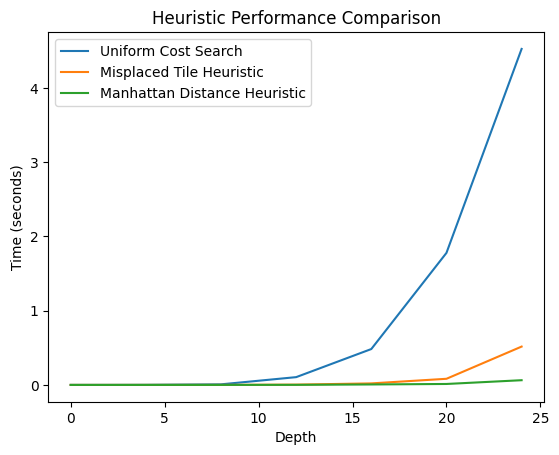

In [9]:
if __name__ == "__main__":
    results = measure_heuristics(problems)
    plot_results(results)